In [1]:
CERT_FILE='./cms/minibias/Cert_136033-149442_7TeV_Apr21ReReco_Collisions10_JSON_v2.txt'

PATH='/mnt/cms/version2/data/'

import numpy as np
import pandas as pd
import os
import os.path as osp

In [2]:
def load_certs(path=CERT_FILE):
    def ranges_to_set(ranges):
        s = set()
        
        for a, b in ranges:
            for i in xrange(a, b + 1):
                s.add(i)
        return s
    
    import json

    with open(path, 'r') as f:
        data = json.load(f)
    
    cert = dict()
    
    for k in data:
        cert[int(k)] = ranges_to_set(data[k])

    return cert

In [3]:
cert = load_certs()

In [4]:
def get_stream_files(path=PATH):
    import os
    import os.path as osp
    
    streams = dict()
    
    for d in (d for d in os.listdir(path) if osp.isdir(osp.join(path, d))):
        d_path = osp.join(path, d)
        streams[d] = [ osp.join(d_path, f) for f in os.listdir(d_path) if f.endswith('.pickled') ]
    
    return streams

In [5]:
def load(path):
    import cPickle as pickle
    
    with open(path, 'r') as f:
        x = pickle.load(f)

    return x

In [6]:
def rename(dataframe, prefix,
           exclude_columns=('run_', 'luminosityBlock_')):
    dataframe.columns = [
        (prefix + column if column not in exclude_columns else column)
        for column in dataframe.columns
    ]
    
    return dataframe

In [7]:
streams = get_stream_files()

In [8]:
[ (k, len(streams[k])) for k, v in streams.items() ]

[('muons', 2979), ('minibias', 1564), ('photons', 2814)]

In [9]:
df = dict()

for stream in streams:
    df[stream] = rename(
        pd.concat([ load(path) for path in streams[stream] ]),
        prefix = stream + '_'
    )

In [10]:
merged = df['minibias'].merge(
    df['muons'], how='outer', on=('run_', 'luminosityBlock_')
).merge(
    df['photons'], how='outer', on=('run_', 'luminosityBlock_')
)

In [11]:
merged = merged.rename(columns = {
    'minibias_instantLumi_' : '_instantLumi_minibias',
    'muons_instantLumi_' : '_instantLumi_muons',
    'photons_instantLumi_' : '_instantLumi_photons',
    'run_' : '_run',
    'luminosityBlock_' : '_luminosityBlock'
}, copy=False)

cs = sorted(merged.columns)

merged = merged[cs]

In [12]:
for c in merged.columns:
    print c

_instantLumi_minibias
_instantLumi_muons
_instantLumi_photons
_luminosityBlock
_run
minibias_PF_Px_mean
minibias_PF_Px_p1
minibias_PF_Px_p25
minibias_PF_Px_p50
minibias_PF_Px_p75
minibias_PF_Px_p99
minibias_PF_Px_std
minibias_PF_Py_mean
minibias_PF_Py_p1
minibias_PF_Py_p25
minibias_PF_Py_p50
minibias_PF_Py_p75
minibias_PF_Py_p99
minibias_PF_Py_std
minibias_PF_Pz_mean
minibias_PF_Pz_p1
minibias_PF_Pz_p25
minibias_PF_Pz_p50
minibias_PF_Pz_p75
minibias_PF_Pz_p99
minibias_PF_Pz_std
minibias_PF_eta__q1_mean
minibias_PF_eta__q1_p1
minibias_PF_eta__q1_p25
minibias_PF_eta__q1_p50
minibias_PF_eta__q1_p75
minibias_PF_eta__q1_p99
minibias_PF_eta__q1_std
minibias_PF_eta__q2_mean
minibias_PF_eta__q2_p1
minibias_PF_eta__q2_p25
minibias_PF_eta__q2_p50
minibias_PF_eta__q2_p75
minibias_PF_eta__q2_p99
minibias_PF_eta__q2_std
minibias_PF_eta__q3_mean
minibias_PF_eta__q3_p1
minibias_PF_eta__q3_p25
minibias_PF_eta__q3_p50
minibias_PF_eta__q3_p75
minibias_PF_eta__q3_p99
minibias_PF_eta__q3_std
minibias_PF_e

In [13]:
merged.fillna(value = 0.0, inplace = True)

In [14]:
labels = np.zeros(len(merged))

index = merged[['_run', '_luminosityBlock']].values

for i in xrange(len(merged)):
    run, block = index[i, :]
    if run in cert and block in cert[run]:
        labels[i] = 1.0
    else:
        labels[i] = 0.0

In [15]:
def is_dist_feature(name):
    return 'mean' in name or 'std' in name or any([ ('p' + str(q)) in name for q in [1, 25, 50, 75, 99] ])

In [16]:
index_columns = [ '_luminosityBlock', '_run' ]
features = list(merged.columns[5:]) + [ '_instantLumi_minibias', '_instantLumi_muons', '_instantLumi_photons']

In [17]:
distribution_features = [ f for f in features if is_dist_feature(f) ]
other_features = [ f for f in features if not is_dist_feature(f) ]

In [18]:
other_features

['minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights',
 '_instantLumi_minibias',
 '_instantLumi_muons',
 '_instantLumi_photons']

In [19]:
for j, postfix in enumerate(['mean'] + [ 'p' + str(q) for q in [1, 25, 50, 75, 99] ] + ['std']):
    for i in xrange(len(distribution_features)):
        if i % 7 == j:
            if not distribution_features[i].endswith('_' + postfix):
                print distribution_features[i]

In [20]:
len(distribution_features)

2688

In [21]:
X = merged[distribution_features + other_features[:3]].values
y = labels

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [24]:
clf = RandomForestClassifier(n_estimators=250, min_samples_leaf=20, n_jobs=-1)

In [25]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
y_predicted = clf.predict_proba(X_test)

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [28]:
score = roc_auc_score(y_test, y_predicted[:, 1])
fpr, tpr, _ = roc_curve(y_test, y_predicted[:, 1])

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

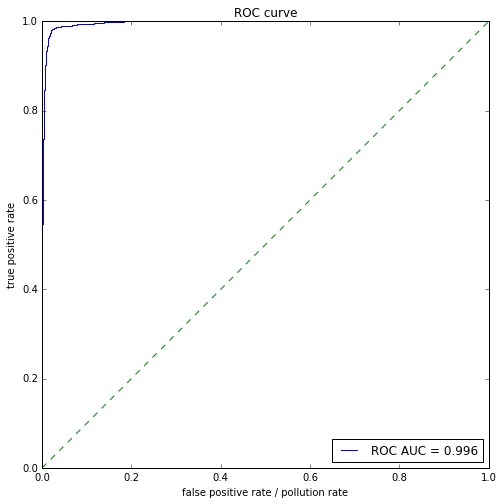

In [30]:
plt.figure(figsize=(8, 8))

plt.title('ROC curve')

plt.plot(fpr, tpr, label='ROC AUC = %.3f' % score )
plt.plot([0,1], [0, 1], '--')
plt.legend(loc='lower right')
plt.xlabel('false positive rate / pollution rate')
plt.ylabel('true positive rate')

In [31]:
merged.to_pickle('/mnt/cms/version2/merged.pickle')

In [32]:
np.mean(labels)

0.54615196078431372

In [33]:
np.save('/mnt/cms/version2/labels', labels)